Download the data

In [ ]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip
!ls

In [ ]:
%matplotlib inline


Classifying Names with a Character-Level RNN
*********************************************
**Author**: `Sean Robertson <https://github.com/spro/practical-pytorch>`_

Building and training a basic character-level RNN to classify
words. A character-level RNN reads words as a series of characters -
outputting a prediction and "hidden state" at each step, feeding its
previous hidden state into each next step. We take the final prediction
to be the output, i.e. which class the word belongs to.

A few thousand surnames from 18 languages
of origin, and predict which language a name is from based on the
spelling:

::

    $ python predict.py Hinton
    (-0.47) Scottish
    (-1.52) English
    (-3.57) Irish

    $ python predict.py Schmidhuber
    (-0.19) German
    (-2.48) Czech
    (-2.68) Dutch

Preparing the Data
==================

.. Note::
   Download the data from
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   and extract it to the current directory.

Included in the ``data/names`` directory are 18 text files named as
"[Language].txt". Each file contains a bunch of names, one name per
line, mostly romanized.




In [7]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import random

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string
import math

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
train_data = {}
validation_data = {}
test_data = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    random.shuffle(lines)
    train_data[category] = lines[0:int(math.floor(0.7*len(lines)))]
    validation_data[category] = lines[int(math.floor(0.7*len(lines)))+1:int(math.floor(0.85*len(lines)))]
    test_data[category] = lines[int(math.floor(0.85*len(lines)))+1:]
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Polish.txt', 'data/names/English.txt', 'data/names/Vietnamese.txt', 'data/names/German.txt', 'data/names/Korean.txt', 'data/names/Portuguese.txt', 'data/names/Spanish.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Italian.txt', 'data/names/Chinese.txt', 'data/names/Scottish.txt', 'data/names/Arabic.txt', 'data/names/Czech.txt', 'data/names/Irish.txt', 'data/names/Greek.txt', 'data/names/Japanese.txt', 'data/names/Dutch.txt']
Slusarski


``category_lines``, a dictionary mapping each category
(language) to a list of lines (names).

``all_categories`` (just a list of languages) and ``n_categories`` for
later reference.


In [ ]:
print(category_lines['Italian'][:5])

['Abello', 'Alcheri', 'Nespola', 'Campo', 'Ruggeri']


Turning Names into Tensors
--------------------------

Turn the organized names turn them into
Tensors to make any use of them.

To represent a single letter, use a "one-hot vector" of size
``<1 x n_letters>``. A one-hot vector is filled with 0s except for a 1
at index of the current letter, e.g. ``"b" = <0 1 0 0 0 ...>``.

To make a word join a bunch of those into a 2D matrix
``<line_length x 1 x n_letters>``.

That extra 1 dimension is because PyTorch assumes everything is in
batches 



In [ ]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


Creating the Network
====================

Before autograd, creating a recurrent neural network in Torch involved
cloning the parameters of a layer over several timesteps. The layers
held hidden state and gradients which are now entirely handled by the
graph itself. This means you can implement a RNN in a very "pure" way,
as regular feed-forward layers.

This RNN module (mostly copied from `the PyTorch for Torch users
tutorial <http://pytorch.org/tutorials/beginner/former_torchies/
nn_tutorial.html#example-2-recurrent-net>`__)
is just 2 linear layers which operate on an input and hidden state, with
a LogSoftmax layer after the output.

.. figure:: https://i.imgur.com/Z2xbySO.png
   :alt:





In [ ]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)      

GRUs
=========

In [16]:
import torch.nn as nn
from torch.autograd import Variable

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.GRUCell(input_size, hidden_size)
        self.i2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        hidden = self.i2h(input, hidden)
        output = self.i2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
gru = GRU(n_letters, n_hidden, n_categories)   

LSTM
==========

In [17]:
import torch.nn as nn
from torch.autograd import Variable

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.LSTMCell(input_size, hidden_size)
        self.i2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        hidden, ct = self.i2h(input, hidden)
        output = self.i2o(hidden)
        output = self.softmax(output)
        return output, (hidden, ct)

    def initHidden(self):
        return (torch.zeros(1, self.hidden_size), torch.zeros(1, self.hidden_size))

n_hidden = 128
lstm = LSTM(n_letters, n_hidden, n_categories)   

To run a step of this network pass an input (in our case, the
Tensor for the current letter) and a previous hidden state (which was
initialize as zeros at first). Get back the output (probability of
each language) and a next hidden state 




In [10]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [20]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = gru(input, hidden)

In [22]:
input = letterToTensor('A')
hidden =(torch.zeros(1, n_hidden),torch.zeros(1, n_hidden))

output, next_hidden = lstm(input, hidden)

For the sake of efficiency don't want create a new Tensor for
every step, use ``lineToTensor`` instead of
``letterToTensor`` and use slices. This could be further optimized by
pre-computing batches of Tensors.




In [ ]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9249, -2.9341, -3.0085, -2.9308, -2.9351, -2.9771, -2.8213, -2.7633,
         -2.8533, -2.8920, -2.8424, -2.8845, -2.8273, -2.9066, -2.9027, -2.8777,
         -2.8920, -2.8818]], grad_fn=<LogSoftmaxBackward0>)


In [23]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = gru(input[0], hidden)
print(output)

tensor([[-2.9445, -2.8073, -2.9592, -2.8596, -2.9785, -2.8782, -2.9450, -2.9061,
         -2.8649, -2.8435, -2.7912, -2.9204, -2.9494, -2.9050, -2.8775, -2.9113,
         -2.8702, -2.8388]], grad_fn=<LogSoftmaxBackward0>)


In [25]:
input = lineToTensor('Albert')
hidden = (torch.zeros(1, n_hidden),torch.zeros(1, n_hidden))

output, next_hidden = lstm(input[0], hidden)
print(output)

tensor([[-2.8180, -2.9632, -2.8800, -2.9388, -2.9122, -2.9400, -2.8215, -2.8513,
         -2.8271, -2.9522, -2.8227, -2.9361, -2.8113, -2.9421, -2.9571, -2.8767,
         -2.9155, -2.8865]], grad_fn=<LogSoftmaxBackward0>)


As you can see the output is a ``<1 x n_categories>`` Tensor, where
every item is the likelihood of that category (higher is more likely).




Training
========
Preparing for Training
----------------------

Before going into training  make a few helper functions. The
first is to interpret the output of the network, use ``Tensor.topk`` to get the index
of the greatest value:




In [26]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Arabic', 12)


We will also want a quick way to get a training example (a name and its
language):




In [27]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(train_data[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = German / line = Huber
category = Japanese / line = Kakutama
category = Vietnamese / line = Ngo
category = Russian / line = Ruzhitsky
category = French / line = Martel
category = Korean / line = Rhee
category = Portuguese / line = Araujo
category = Arabic / line = Hanania
category = Greek / line = Kotsilimbas
category = Portuguese / line = D'cruze


Training the Network
--------------------

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it's wrong.

For the loss function ``nn.NLLLoss`` is appropriate, since the last
layer of the RNN is ``nn.LogSoftmax``.




In [28]:
criterion = nn.NLLLoss()

Each loop of training will:

-  Create input and target tensors
-  Create a zeroed initial hidden state
-  Read each letter in and

   -  Keep hidden state for next letter

-  Compare final output to target
-  Back-propagate
-  Return the output and loss




Hidden Linear Unit
=========

In [29]:
optimizer = torch.optim.Adam(rnn.parameters())

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    # reset gradient
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    loss = criterion(output, category_tensor)

    # compute gradient by backpropagation
    loss.backward()

    # update parameters
    optimizer.step()

    return output, loss.item()

GRU
=======

In [31]:
optimizer = torch.optim.Adam(gru.parameters())

def train(category_tensor, line_tensor):
    hidden = gru.initHidden()

    # reset gradient
    gru.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = gru(line_tensor[i], hidden)
    loss = criterion(output, category_tensor)

    # compute gradient by backpropagation
    loss.backward()

    # update parameters
    optimizer.step()

    return output, loss.item()

LSTM
========

In [33]:
optimizer = torch.optim.Adam(lstm.parameters())

def train(category_tensor, line_tensor):
    hidden = lstm.initHidden()

    # reset gradient
    lstm.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = lstm(line_tensor[i], hidden)
    loss = criterion(output, category_tensor)

    # compute gradient by backpropagation
    loss.backward()

    # update parameters
    optimizer.step()

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the
``train`` function returns both the output and loss we can print its
guesses and also keep track of loss for plotting. Since there are 1000s
of examples we print only every ``print_every`` examples, and take an
average of the loss.




Hidden Linear Unit Results
=========

In [30]:
import time
import math

n_iters = 80000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
train_loss = 0
all_train_losses = []
all_validation_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    return output

def eval_dataset(dataset):
    loss = 0
    n_instances = 0
    confusion = torch.zeros(n_categories, n_categories)
    for category in all_categories:
        category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
        n_instances += len(dataset[category])
        for line in dataset[category]:
            line_tensor = Variable(lineToTensor(line))
            output = evaluate(line_tensor)
            loss += criterion(output, category_tensor)
            guess, guess_i = categoryFromOutput(output)
            category_i = all_categories.index(category)
            confusion[category_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()

    return loss.item() / n_instances, confusion
  
print('\nIter \tTrain% \tTime \t\tTrain_loss \tExample')
start = time.time()
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    train_loss += loss

    # Print iter number, train loss average, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d \t%d%% \t(%s) \t%.4f \t\t%s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), train_loss / plot_every, line, guess, correct))

    # Add current train loss average to list of losses
    if iter % plot_every == 0:
        all_train_losses.append(train_loss / plot_every)
        train_loss = 0
        
    # Compute loss based on validation data
    if iter % plot_every == 0:
        average_validation_loss, _ = eval_dataset(validation_data)

        # save model with best validation loss
        if len(all_validation_losses) == 0 or average_validation_loss < min(all_validation_losses):
            torch.save(rnn, 'char_rnn_classification_model.pt')
        all_validation_losses.append(average_validation_loss)



Iter 	Train% 	Time 		Train_loss 	Example
5000 	6% 	(0m 18s) 	1.8726 		Antoun / French ✗ (Arabic)
10000 	12% 	(0m 38s) 	1.6170 		Lihodeev / Russian ✓
15000 	18% 	(0m 57s) 	1.4486 		Eatros / Greek ✓
20000 	25% 	(1m 17s) 	1.3954 		Corraidhin / Irish ✓
25000 	31% 	(1m 36s) 	1.3276 		Kolovos / Greek ✓
30000 	37% 	(1m 56s) 	1.3042 		Mcgregor / French ✗ (Scottish)
35000 	43% 	(2m 14s) 	1.2577 		Rompaye / French ✗ (Dutch)
40000 	50% 	(2m 34s) 	1.1645 		Handal / Czech ✗ (Arabic)
45000 	56% 	(2m 53s) 	1.2324 		Morioka / Czech ✗ (Japanese)
50000 	62% 	(3m 12s) 	1.1896 		Zha / Chinese ✓
55000 	68% 	(3m 31s) 	1.1953 		Crocker / French ✗ (English)
60000 	75% 	(3m 50s) 	1.1297 		Banh / Vietnamese ✓
65000 	81% 	(4m 9s) 	1.1695 		Hayashida / Japanese ✓
70000 	87% 	(4m 28s) 	1.1538 		Cha / Korean ✓
75000 	93% 	(4m 47s) 	1.1586 		Frusher / German ✗ (English)
80000 	100% 	(5m 6s) 	1.1183 		Grulich / English ✗ (Czech)


GRU Results
=======

In [32]:
import time
import math

n_iters = 80000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
train_loss_GRU = 0
all_train_losses_GRU = []
all_validation_losses_GRU = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Just return an output given a line
def evaluate_GRU(line_tensor):
    hidden = gru.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = gru(line_tensor[i], hidden)
    return output

def eval_dataset_GRU(dataset):
    loss = 0
    n_instances = 0
    confusion_GRU = torch.zeros(n_categories, n_categories)
    for category in all_categories:
        category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
        n_instances += len(dataset[category])
        for line in dataset[category]:
            line_tensor = Variable(lineToTensor(line))
            output = evaluate_GRU(line_tensor)
            loss += criterion(output, category_tensor)
            guess, guess_i = categoryFromOutput(output)
            category_i = all_categories.index(category)
            confusion_GRU[category_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion_GRU[i] = confusion_GRU[i] / confusion_GRU[i].sum()

    return loss.item() / n_instances, confusion_GRU
  
print('\nIter \tTrain% \tTime \t\tTrain_loss \tExample')
start = time.time()
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    train_loss_GRU += loss

    # Print iter number, train loss average, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d \t%d%% \t(%s) \t%.4f \t\t%s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), train_loss_GRU / plot_every, line, guess, correct))

    # Add current train loss average to list of losses
    if iter % plot_every == 0:
        all_train_losses_GRU.append(train_loss_GRU / plot_every)
        train_loss_GRU = 0
        
    # Compute loss based on validation data
    if iter % plot_every == 0:
        average_validation_loss_GRU, _ = eval_dataset_GRU(validation_data)

        # save model with best validation loss
        if len(all_validation_losses_GRU) == 0 or average_validation_loss_GRU < min(all_validation_losses_GRU):
            torch.save(gru, 'char_gru_classification_model.pt')
        all_validation_losses_GRU.append(average_validation_loss_GRU)



Iter 	Train% 	Time 		Train_loss 	Example
5000 	6% 	(0m 39s) 	1.4716 		San / Chinese ✗ (Korean)
10000 	12% 	(1m 22s) 	1.0785 		Chastain / French ✓
15000 	18% 	(2m 5s) 	0.9940 		Shum / Korean ✗ (Chinese)
20000 	25% 	(2m 48s) 	0.7323 		Lucas / Spanish ✗ (Dutch)
25000 	31% 	(3m 31s) 	0.6281 		Shannon / Irish ✓
30000 	37% 	(4m 14s) 	0.5809 		Okenfuss / Greek ✗ (Czech)
35000 	43% 	(4m 56s) 	0.4813 		Reid / Scottish ✓
40000 	50% 	(5m 39s) 	0.3570 		Garver / German ✓
45000 	56% 	(6m 21s) 	0.4104 		Bosko / Polish ✓
50000 	62% 	(7m 5s) 	0.3289 		Wyrzyk / Polish ✓
55000 	68% 	(7m 48s) 	0.3146 		Jankelevich / Czech ✗ (Russian)
60000 	75% 	(8m 31s) 	0.3305 		Rey / Spanish ✓
65000 	81% 	(9m 14s) 	0.2509 		Paraskevopoulos / Greek ✓
70000 	87% 	(9m 56s) 	0.2991 		Rossini / Italian ✓
75000 	93% 	(10m 40s) 	0.1913 		Ma / Vietnamese ✓
80000 	100% 	(11m 23s) 	0.2167 		Murray / Scottish ✓


LSTM
========

In [34]:
import time
import math

n_iters = 80000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
train_loss_LSTM = 0
all_train_losses_LSTM = []
all_validation_losses_LSTM = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Just return an output given a line
def evaluate_LSTM(line_tensor):
    hidden = lstm.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = lstm(line_tensor[i], hidden)
    return output

def eval_dataset_LSTM(dataset):
    loss = 0
    n_instances = 0
    confusion_LSTM = torch.zeros(n_categories, n_categories)
    for category in all_categories:
        category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
        n_instances += len(dataset[category])
        for line in dataset[category]:
            line_tensor = Variable(lineToTensor(line))
            output = evaluate_LSTM(line_tensor)
            loss += criterion(output, category_tensor)
            guess, guess_i = categoryFromOutput(output)
            category_i = all_categories.index(category)
            confusion_LSTM[category_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion_LSTM[i] = confusion_LSTM[i] / confusion_LSTM[i].sum()

    return loss.item() / n_instances, confusion_LSTM
  
print('\nIter \tTrain% \tTime \t\tTrain_loss \tExample')
start = time.time()
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    train_loss_LSTM += loss

    # Print iter number, train loss average, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d \t%d%% \t(%s) \t%.4f \t\t%s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), train_loss_LSTM / plot_every, line, guess, correct))

    # Add current train loss average to list of losses
    if iter % plot_every == 0:
        all_train_losses_LSTM.append(train_loss_LSTM / plot_every)
        train_loss_LSTM = 0
        
    # Compute loss based on validation data
    if iter % plot_every == 0:
        average_validation_loss_LSTM, _ = eval_dataset_LSTM(validation_data)

        # save model with best validation loss
        if len(all_validation_losses_LSTM) == 0 or average_validation_loss_LSTM < min(all_validation_losses_LSTM):
            torch.save(lstm, 'char_LSTM_classification_model.pt')
        all_validation_losses_LSTM.append(average_validation_loss_LSTM)



Iter 	Train% 	Time 		Train_loss 	Example
5000 	6% 	(0m 40s) 	1.6677 		Batsakis / Greek ✓
10000 	12% 	(1m 24s) 	1.2311 		Sin / Korean ✓
15000 	18% 	(2m 9s) 	1.0086 		Botros / Arabic ✓
20000 	25% 	(2m 54s) 	0.8743 		O'Keeffe / Irish ✓
25000 	31% 	(3m 38s) 	0.7300 		San / Chinese ✗ (Korean)
30000 	37% 	(4m 23s) 	0.6450 		Mclaughlin / Scottish ✓
35000 	43% 	(5m 8s) 	0.4497 		Urista / Czech ✓
40000 	50% 	(5m 53s) 	0.4456 		To The First Page / English ✗ (Russian)
45000 	56% 	(6m 37s) 	0.4060 		Peter / Spanish ✗ (Dutch)
50000 	62% 	(7m 21s) 	0.4057 		Grozmanova / Czech ✓
55000 	68% 	(8m 6s) 	0.3834 		Seelenfreund / German ✓
60000 	75% 	(8m 51s) 	0.2913 		Ahn / Korean ✓
65000 	81% 	(9m 34s) 	0.2850 		Parensov / Russian ✓
70000 	87% 	(10m 19s) 	0.2724 		Wright / Scottish ✓
75000 	93% 	(11m 3s) 	0.3023 		Wright / Scottish ✓
80000 	100% 	(11m 47s) 	0.2456 		Chang / Korean ✓


Plotting the Results
--------------------

Plotting the historical loss from ``all_losses`` shows the network
learning:




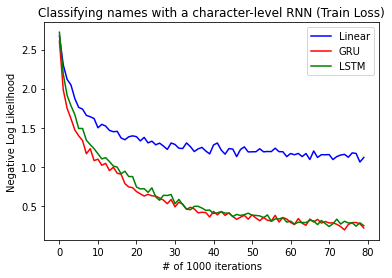

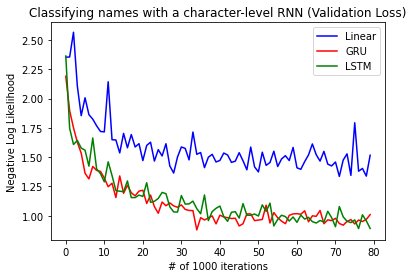

In [43]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_train_losses, color = "blue", label = "Linear")
plt.plot(all_train_losses_GRU, color = "red", label = "GRU")
plt.plot(all_train_losses_LSTM, color = "green", label = "LSTM")


plt.title('Classifying names with a character-level RNN (Train Loss)')
plt.ylabel('Negative Log Likelihood')
plt.xlabel('# of 1000 iterations')
plt.legend(loc='upper right')


plt.figure()
plt.plot(all_validation_losses, color = "blue", label = "Linear")
plt.plot(all_validation_losses_GRU, color = "red", label = "GRU")
plt.plot(all_validation_losses_LSTM, color = "green", label = "LSTM")

plt.title('Classifying names with a character-level RNN (Validation Loss)')
plt.ylabel('Negative Log Likelihood')
plt.xlabel('# of 1000 iterations')
plt.legend(loc='upper right')

Explanation 
=======
Linear hidden units are very simple and good for use cases where input is linearly transformed and has been passed through an activation function. But this they can't capture complex patterns and dependencies as well as GRUs and LSTMs.

GRUs have fewer parameters to learn and faster training times but suffers with tasks that require more precise memory storage.

LSTMs have more memory cells and gates that regulate information flow which works well for language modelling and speech recognition etc.

Evaluating the Results
======================

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples are run through the network with
``evaluate()``, which is the same as ``train()`` minus the backprop.




Hidden Linear Units
========

Average test loss: 1.3132171274939604


<ipython-input-36-204be60d7dad>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-36-204be60d7dad>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


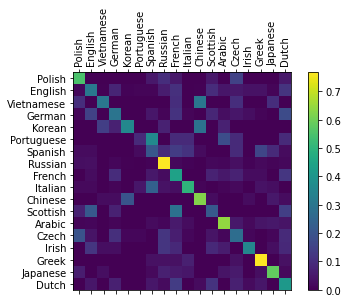

In [36]:
# evaluate on test set and display confusion matrix
rnn = torch.load('char_rnn_classification_model.pt')
average_test_loss, confusion = eval_dataset(test_data)
print('Average test loss: ' + str(average_test_loss))

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

GRU
=======

Average test loss: 0.9284028533457598


<ipython-input-37-8b6f2266bc5c>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-37-8b6f2266bc5c>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


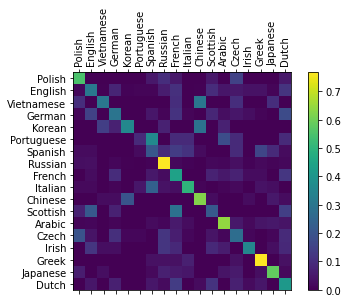

In [37]:
# evaluate on test set and display confusion matrix
gru = torch.load('char_gru_classification_model.pt')
average_test_loss_GRU, confusion_GRU = eval_dataset_GRU(test_data)
print('Average test loss: ' + str(average_test_loss_GRU))

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

LSTM
======

Average test loss: 0.9183122227486671


<ipython-input-38-452c175fae87>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-38-452c175fae87>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


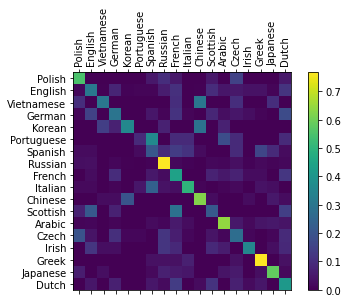

In [38]:
# evaluate on test set and display confusion matrix
lstm = torch.load('char_LSTM_classification_model.pt')
average_test_loss_LSTM, confusion_LSTM = eval_dataset_LSTM(test_data)
print('Average test loss: ' + str(average_test_loss_LSTM))

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

You can pick out bright spots off the main axis that show which
languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish
for Italian. It seems to do very well with Greek, and very poorly with
English (perhaps because of overlap with other languages).




Running on User Input
---------------------




In [39]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.11) Russian
(-2.85) Czech
(-3.31) English

> Jackson
(-0.36) Scottish
(-1.94) English
(-2.20) Russian

> Satoshi
(-0.56) Arabic
(-1.68) Italian
(-2.41) Polish


The final versions of the scripts `in the Practical PyTorch
repo <https://github.com/spro/practical-pytorch/tree/master/char-rnn-classification>`__
split the above code into a few files:

-  ``data.py`` (loads files)
-  ``model.py`` (defines the RNN)
-  ``train.py`` (runs training)
-  ``predict.py`` (runs ``predict()`` with command line arguments)
-  ``server.py`` (serve prediction as a JSON API with bottle.py)

Run ``train.py`` to train and save the network.

Run ``predict.py`` with a name to view predictions:

::

    $ python predict.py Hazaki
    (-0.42) Japanese
    (-1.39) Polish
    (-3.51) Czech

Run ``server.py`` and visit http://localhost:5533/Yourname to get JSON
output of predictions.




Exercises
=========

-  Try with a different dataset of line -> category, for example:

   -  Any word -> language
   -  First name -> gender
   -  Character name -> writer
   -  Page title -> blog or subreddit

-  Get better results with a bigger and/or better shaped network

   -  Add more linear layers
   -  Try the ``nn.LSTM`` and ``nn.GRU`` layers
   -  Combine multiple of these RNNs as a higher level network


